In [1]:
%%capture
pip install -q git+https://github.com/huggingface/transformers qwen-vl-utils  quanto accelerate flash-attn

In [2]:
import torch
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
from accelerate import init_empty_weights, infer_auto_device_map
import requests
from PIL import Image
import matplotlib.pyplot as plt

###  Load the model and processor with appropriate device mapping

In [3]:
def load_model_and_processor(model_path):
    
    with init_empty_weights():
        model = Qwen2VLForConditionalGeneration.from_pretrained(
            model_path,
            attn_implementation="flash_attention_2",
            torch_dtype="auto",
        )
    device_map = infer_auto_device_map(
        model,
        max_memory={0: "7GiB", "cpu": "15GiB"}
    )
    
    # Reload with device_map
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        model_path,
        device_map=device_map,
        torch_dtype=torch.bfloat16, 
    )
    
    processor = AutoProcessor.from_pretrained(
        model_path,
        min_pixels=256 * 28 * 28,
        max_pixels=1024 * 28 * 28
    )
    
    return model, processor


In [4]:
def prepare_inputs(messages, processor, text_prompt):
    """
    Prepare the inputs for the model by combining vision and text information.
    """
  
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    
    image_inputs, video_inputs = process_vision_info(messages)
 
    inputs = processor(
        text=[text_prompt + text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    )
    return inputs


In [5]:
def display_image_with_caption(image_url, caption):
    response = requests.get(image_url, stream=True)
    image = Image.open(response.raw)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title(caption, fontsize=16, wrap=True)
    plt.show()

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:2068: UserWarning: for visual.patch_embed.proj.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:2068: UserWarning: for visual.blocks.0.norm1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/usr/local/lib/python3.10/dist-packages/torc

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Generating outputs...
Caption: The image depicts a woman and her dog enjoying a serene moment on a sandy beach. The woman is sitting on the sand, facing the ocean, and appears to be engaging with her dog. The dog, which is wearing a harness, is sitting in front of the woman and seems to be giving her a high-five. The beach is relatively empty, with gentle waves in the background. The lighting suggests it is either early morning or late afternoon, as the sun is low on the horizon, casting a warm, golden glow over the scene. The overall atmosphere is peaceful and relaxed.


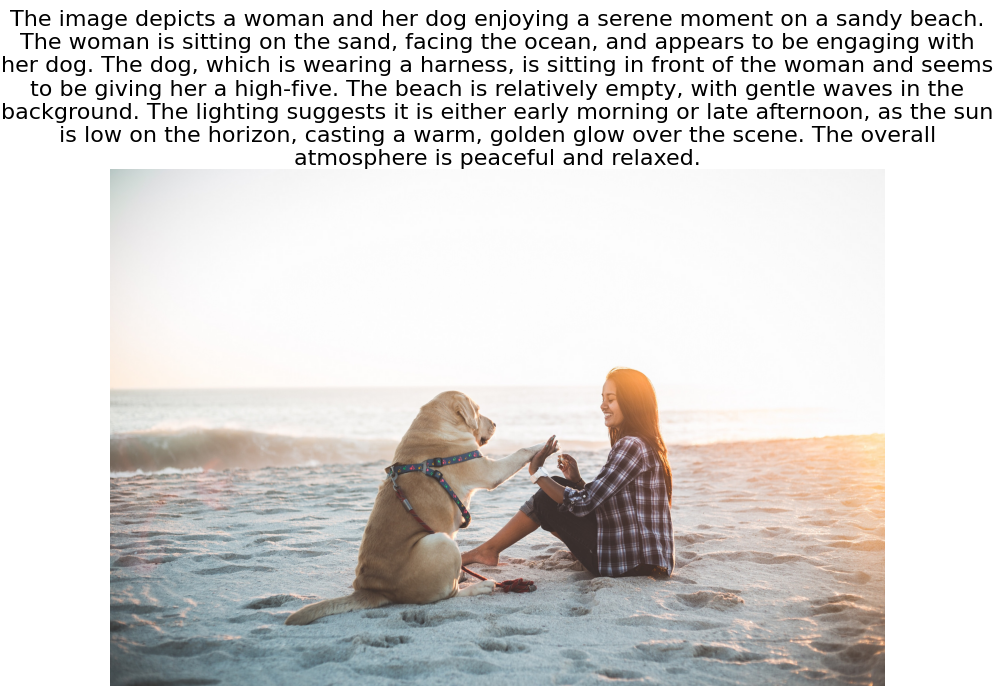

In [6]:
if __name__ == "__main__":
    model_name = "/kaggle/input/qwen2-vl/transformers/7b-instruct/1"
    input_image_url = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg"
  
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": input_image_url},
                {"type": "text", "text": "Describe this image."},
            ],
        }
    ]
    text_prompt = "Please analyze the following image and provide a description: "

    model, processor = load_model_and_processor(model_name)

    inputs = prepare_inputs(messages, processor, text_prompt)
    inputs = {k: v.to("cuda:0") for k, v in inputs.items()}

    print("Generating outputs...")
    try:
        generated_ids = model.generate(**inputs, max_new_tokens=128)
        generated_ids_trimmed = [
            out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs["input_ids"], generated_ids)
        ]
        output_text = processor.batch_decode(
            generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
        )
        caption = output_text[0]
        print("Caption:", caption)

    
        display_image_with_caption(input_image_url, caption)
    except torch.cuda.OutOfMemoryError as e:
        print("CUDA Out of Memory Error:", e)
